# Data Audit

In [2]:
import pandas as pd
import numpy as np
import scipy as sp 
import matplotlib as plt
import matplotlib.pyplot as pltp
import plotly.plotly as py 
import missingno as msno
from statsmodels.graphics.mosaicplot import mosaic
import seaborn as sns
from collections import Counter
from __future__ import print_function
%matplotlib inline
pd.set_option('max_rows',300)
pd.set_option('max_columns',200)

In [3]:
from general_helpers import *

In [4]:
# Load up data
ac=pd.read_csv("../accountability_console_2018-02-24.csv")

ac_benchmarks = pd.read_csv("../ac_benchmarks_data_2018-05-11.csv")

datecols = ['Filing Date','Registration Date','Eligibility Date','Dispute Resolution Start','Dispute Resolution End','Compliance Review Start',
            'Compliance Review End', 'Monitoring Start', 'Monitoring End','Date Closed' ]

for col in datecols:
    ac[col] = pd.to_datetime(ac[col])

# Benchmark Data 

In [25]:
ac_benchmarks.head()

,Category,Benchmark,AfDB IRM,ADB SPF CRP,EBRD PCM,EIB CM,IFC CAO,IDB MICI,OPIC OA,WB Panel
0,Budget,Is the mechanism's budget approved by the Board?,No,Yes,No,NaN,NaN,Yes,NaN,Yes
1,Budget,Does the mechanism control its own budget?,Yes,No,Yes,Yes,Yes,Yes,No,Yes
2,Budget,May the mechanism request additional funds if ...,NaN,Yes,NaN,NaN,Yes,Yes,NaN,Yes
3,Compliance review findings or recommendations,May claimants make comments on draft recommend...,No,NaN,Yes,Yes,N/A no CR recs,Yes,No,NaN
4,Compliance review findings or recommendations,Are draft recommendations made available to cl...,No,NaN,Yes,Yes,N/A no CR recs,Yes,No,NaN


In [6]:
benchmark_melted = pd.melt(ac_benchmarks, id_vars=["Category",'Benchmark'], 
                 var_name="BankAnswer")

In [7]:
benchmarks_grouped = pd.DataFrame(benchmark_melted.groupby(['Category','Benchmark'])['BankAnswer','value'].agg(lambda x: tuple(x))).reset_index()

In [8]:
benchmarks_grouped['uniq_answers'] = [len(set(i)) for i in benchmarks_grouped['value'].tolist()]

Lets keep only those rows where there are more than 1 answer (variance)

In [9]:
benchmarks_grouped  = benchmarks_grouped[benchmarks_grouped.uniq_answers > 1]

In [29]:
benchmarks_grouped.Category.nunique()

33

In [30]:
benchmarks_grouped.shape

(188, 7)

Which benchmarks are msot important:
Maybe
1. Eligibility requirements
2. Compliance review findings or recommendations


Samer will follow up the policy team on which to prioritize. 

In [32]:
benchmarks_grouped.Category.value_counts()

Initial screening and response to a claim                               15
Sequencing issues - for mechanisms with dual functions                  13
Public Access to the mechanism/ Outreach                                12
Staffing of Secretariat (Mechanism Staff)                               12
Staffing of Panellists/ Experts                                         11
Eligibility requirements                                                11
Transparency                                                            10
Compliance review findings or recommendations                            9
Outcomes of the Compliance Review or Problem-solving Initiative          9
Timeline for Handling Claims (in business days unless noted wth "*")     7
Decision-making During the Mechanism's Process                           6
Investigation authority during compliance review                         6
Monitoring and Follow-up of Outcomes of Mechanism Process                6
Determination of which fu

In [33]:
benchmarks_grouped.head()

,Category,Benchmark,BankAnswer,value,uniq_answers,simple_answers,master_label
0,Budget,Does the mechanism control its own budget?,"(AfDB IRM, ADB SPF CRP, EBRD PCM, EIB CM, IFC ...","(Yes, No, Yes, Yes, Yes, Yes, No, Yes)",2,"[Yes, No]",Budget_Does the mechanism control its own budget?
1,Budget,Is the mechanism's budget approved by the Board?,"(AfDB IRM, ADB SPF CRP, EBRD PCM, EIB CM, IFC ...","(No, Yes, No, nan, nan, Yes, nan, Yes)",3,"[Unknown, Yes, No]",Budget_Is the mechanism's budget approved by t...
2,Budget,May the mechanism request additional funds if ...,"(AfDB IRM, ADB SPF CRP, EBRD PCM, EIB CM, IFC ...","(nan, Yes, nan, nan, Yes, Yes, nan, Yes)",2,"[Unknown, Yes]",Budget_May the mechanism request additional fu...
3,Compliance review findings or recommendations,Are claimants informed of draft findings befor...,"(AfDB IRM, ADB SPF CRP, EBRD PCM, EIB CM, IFC ...","(No, Yes, Yes, Yes, No, Yes, No, No)",2,"[Yes, No]",Compliance review findings or recommendations_...
4,Compliance review findings or recommendations,Are draft findings made available to claimant?,"(AfDB IRM, ADB SPF CRP, EBRD PCM, EIB CM, IFC ...","(No, Yes, Yes, Yes, No, Yes, No, nan)",3,"[Unknown, Yes, No]",Compliance review findings or recommendations_...


Lets code the answers as Yes/No/Missing/Other 

In [12]:
def simplify_answers(answer_tuple):
    simple_answers = ['Unknown','Yes','No','Other']
    answer_tuple = list(set(answer_tuple))
    answer_tuple = [i if pd.notnull(i) else 'Unknown' for i in answer_tuple]
    answer_tuple = [i if i in simple_answers else 'Other' for i in answer_tuple]

    return answer_tuple
    
simplify_answers(('Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes',np.nan, 'rando'))

['Unknown', 'Yes', 'Other', 'No']

In [13]:
benchmarks_grouped.is_copy = False
benchmarks_grouped['simple_answers'] = benchmarks_grouped['value'].apply(simplify_answers)

In [14]:
bank_translate_s2l = {
    'AfDB IRM':'African Development Bank',
    'ADB SPF CRP':'Asian Development Bank',
    'EBRD PCM':'European Bank for Reconstruction and Development',
    'EIB CM':'European Investment Bank',
    'IFC CAO':'IFC/MIGA',
    'IDB MICI':'Inter-American Development Bank',
    'OPIC OA':'Overseas Private Investment Corporation',
    'WB Panel':'World Bank'
}

bank_translate_l2s = dict((v,k) for k,v in bank_translate_s2l.iteritems())


In [15]:
benchmarks_grouped['master_label'] = benchmarks_grouped.apply(lambda row: row['Category'] + '_'+row['Benchmark'], axis=1)

------------------------

# Complaint Data 

In [16]:
ac.dtypes

Complaint Name                       object
Project                              object
Country                              object
IAM                                  object
Bank                                 object
External ID                          object
Status                               object
Filer                                object
IFI Support                          object
Sector                               object
Issues                               object
Description                          object
Non-Compliance Found                   bool
Filing Date                  datetime64[ns]
Registration Date            datetime64[ns]
Eligibility Date             datetime64[ns]
If No Eligibility, Why?              object
Dispute Resolution Start     datetime64[ns]
Dispute Resolution End       datetime64[ns]
Dispute Resolution Status            object
If No DR, Why?                       object
Compliance Review Start      datetime64[ns]
Compliance Review End        dat

In [17]:
data, colordf = color_code_summary(ac)
colordf

SHAPE (815, 29)


,col,datatype,min,max,mean_or_most_common,num_uniq,null_count,null_pct
0,Complaint Name,object,NA,NA,"[('Panama Canal Expansion', 2)]",813,0,0
1,Project,object,NA,NA,"[(nan, 90)]",684,90,0.110429
2,Country,object,NA,NA,"[(nan, 84)]",126,84,0.103067
3,IAM,object,NA,NA,"[('IFC/MIGA Compliance Advisor/Ombudsman (IFC CAO)', 262)]",14,2,0.00245399
4,Bank,object,NA,NA,"[('IFC/MIGA', 262)]",13,2,0.00245399
5,External ID,object,NA,NA,"[(nan, 8)]",746,8,0.00981595
6,Status,object,NA,NA,"[('Closed Without Results', 546)]",6,0,0
7,Filer,object,NA,NA,"[(nan, 311)]",224,311,0.381595
8,IFI Support,object,NA,NA,"[('Project/investment lending', 399)]",12,284,0.348466
9,Sector,object,NA,NA,"[('Infrastructure', 180)]",53,158,0.193865


In [36]:
ac.shape[0]-ac[ac['Eligibility Date'].notnull()].shape[0]

533

In [24]:
1- (282/(ac.shape[0]*1.0))

0.6539877300613497

**Fields Thata are Less than 25% Null **

In [18]:
# data[data.null_pct < .25]

In [19]:
# print(ac.Status.value_counts())
# print(ac.shape)
ac.loc[0]

Complaint Name                           4 MW Hydro Power Project Thack Chilas
Project                                  4 MW Hydro Power Project Thack Chilas
Country                                                               Pakistan
IAM                          Asian Development Bank Special Project Facilit...
Bank                                                    Asian Development Bank
External ID                                                        no_id_25_24
Status                                                  Closed Without Results
Filer                                                                      NaN
IFI Support                                                                NaN
Sector                                                                     NaN
Issues                                                             Procurement
Description                                                                NaN
Non-Compliance Found                                

In [27]:
(46+114+29)/815.

0.23190184049079754

In [24]:
# #missing data
# total = ac.isnull().sum().sort_values(ascending=False)
# percent = (ac.isnull().sum()/ac.isnull().count()).sort_values(ascending=False)
# missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
# missing_data

In [7]:
ac.describe()

,Complaint Name,Project,Country,IAM,Bank,External ID,Status,Filer,IFI Support,Sector,...,Dispute Resolution Status,"If No DR, Why?",Compliance Review Start,Compliance Review End,Compliance Report Issued,"If No CR, Why?",Monitoring Start,Monitoring End,"If No Monitoring, Why?",Date Closed
count,815,725,731,813,813,807,815,504,531,657,...,801,655,141,110,815,629,94,63,673,549
unique,813,684,126,14,13,746,6,224,12,53,...,2,12,131,105,2,16,85,61,11,153
top,Panama Canal Expansion,Rehabilitation of the Railway in Cambodia Project,India,IFC/MIGA Compliance Advisor/Ombudsman (IFC CAO),IFC/MIGA,99,Closed Without Results,Unknown,Project/investment lending,Infrastructure,...,Not Undertaken,Complaint originally deemed ineligible,2015-06-01 00:00:00,2010-10-15 00:00:00,False,Complaint originally deemed ineligible,2006-07-01 00:00:00,2013-06-01 00:00:00,Complaint originally deemed ineligible,2013-07-01 00:00:00
freq,2,5,64,262,262,5,546,244,399,180,...,690,385,3,2,728,407,3,2,388,14
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1994-12-16 00:00:00,1995-06-16 00:00:00,NaN,NaN,2001-06-01 00:00:00,2005-01-01 00:00:00,NaN,1995-04-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2015-12-03 00:00:00,2015-12-03 00:00:00,NaN,NaN,2015-10-29 00:00:00,2015-12-10 00:00:00,NaN,2015-12-01 00:00:00


# General Missingness 

(815, 29)


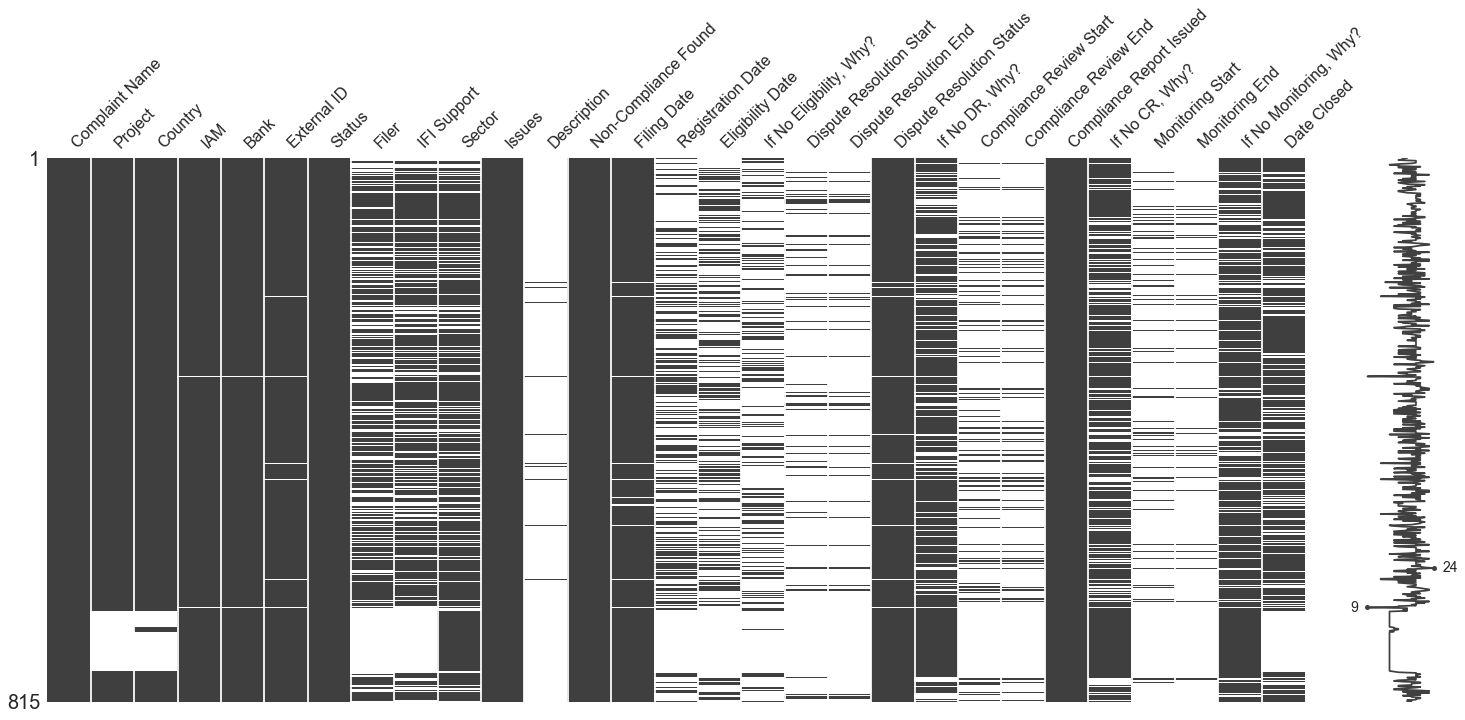

In [39]:
print(ac.shape)
msno.matrix(ac)

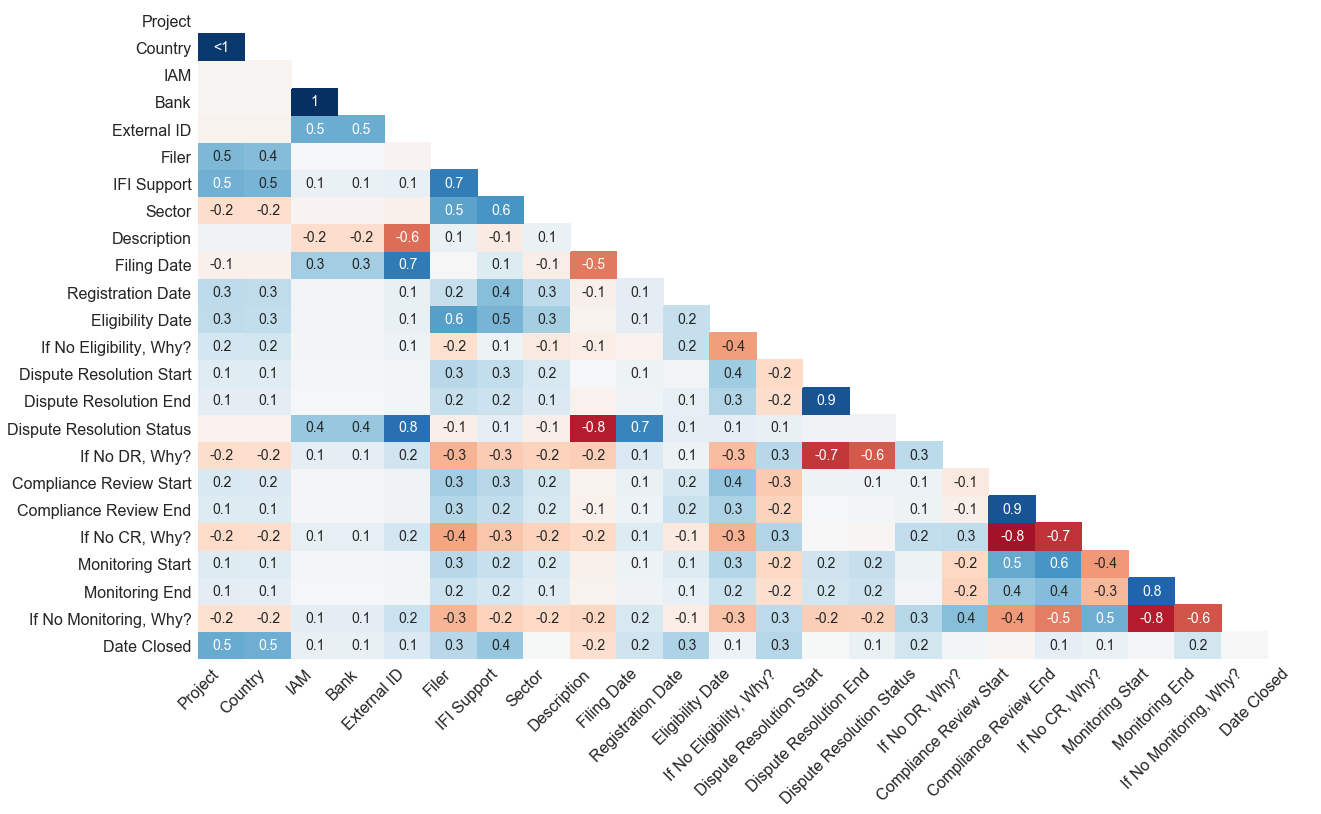

In [40]:
msno.heatmap(ac)

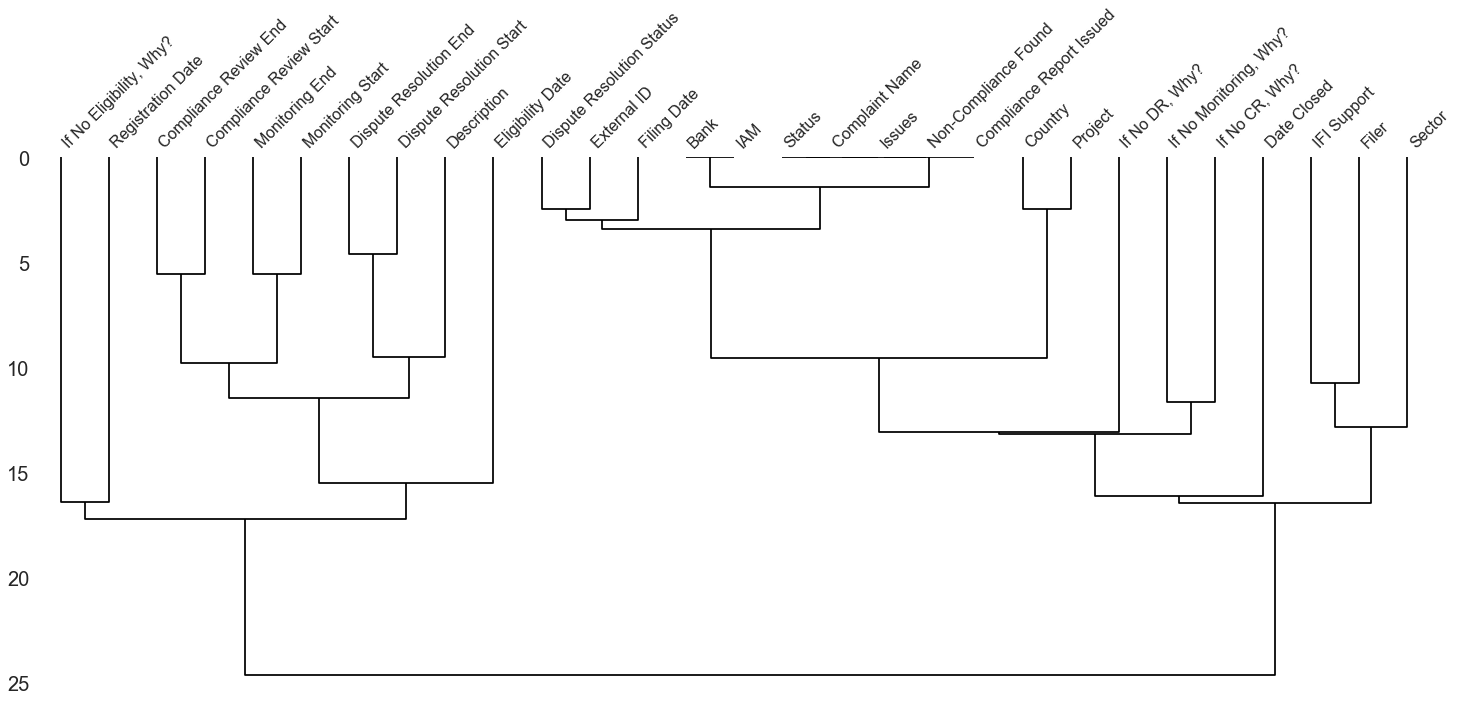

In [41]:
msno.dendrogram(ac)

# Exploring Individual Columns

* **Complaint name**: Complaint Identifier

* **Project**: Name of Development Project (e.g. 'Rehabilitation of the Railway in Cambodia Project') 

* **Country**: Country of Development Project

* **IAM**: Accountability Offices (14 in total) 

* **Bank**: (13 in total) 

## Project

Contains mostly unique name of projects

In [37]:
project_size=pd.value_counts(ac['Project'].values, sort=True, ascending=False)
project_size.head(20)

Rehabilitation of the Railway in Cambodia Project                   5
Unknown                                                             5
Public Road Project                                                 4
Tbilisi Railway Bypass                                              4
Kerala Sustainable Urban Development Project                        3
Valencia Centros Escolares II - 2                                   3
CAREC Transport Corridor I Investment Program                       3
Proyecto Rodoanel Mario Covas - Tramo Norte                         2
Esquema Cajamarquilla, Nievera y Cerro Camote                       2
Pando-Monte Lirio Hydroelectric Power Project                       2
Panama Canal Expansion                                              2
Municipal and Regional Infrastructure Loan                          2
Integrated Citarum Water Resources Management Investment Program    2
Terminal Contenedores Cadiz                                         2
El Dorado Internatio

## Country 

Country of the project and complaint

In [11]:
#country_size = ac.groupby(["Country"]).size()
country_size=pd.value_counts(ac['Country'].values, sort=True, ascending=False)
country_size.head()

India        64
Georgia      42
Brazil       32
Pakistan     27
Argentina    26
dtype: int64

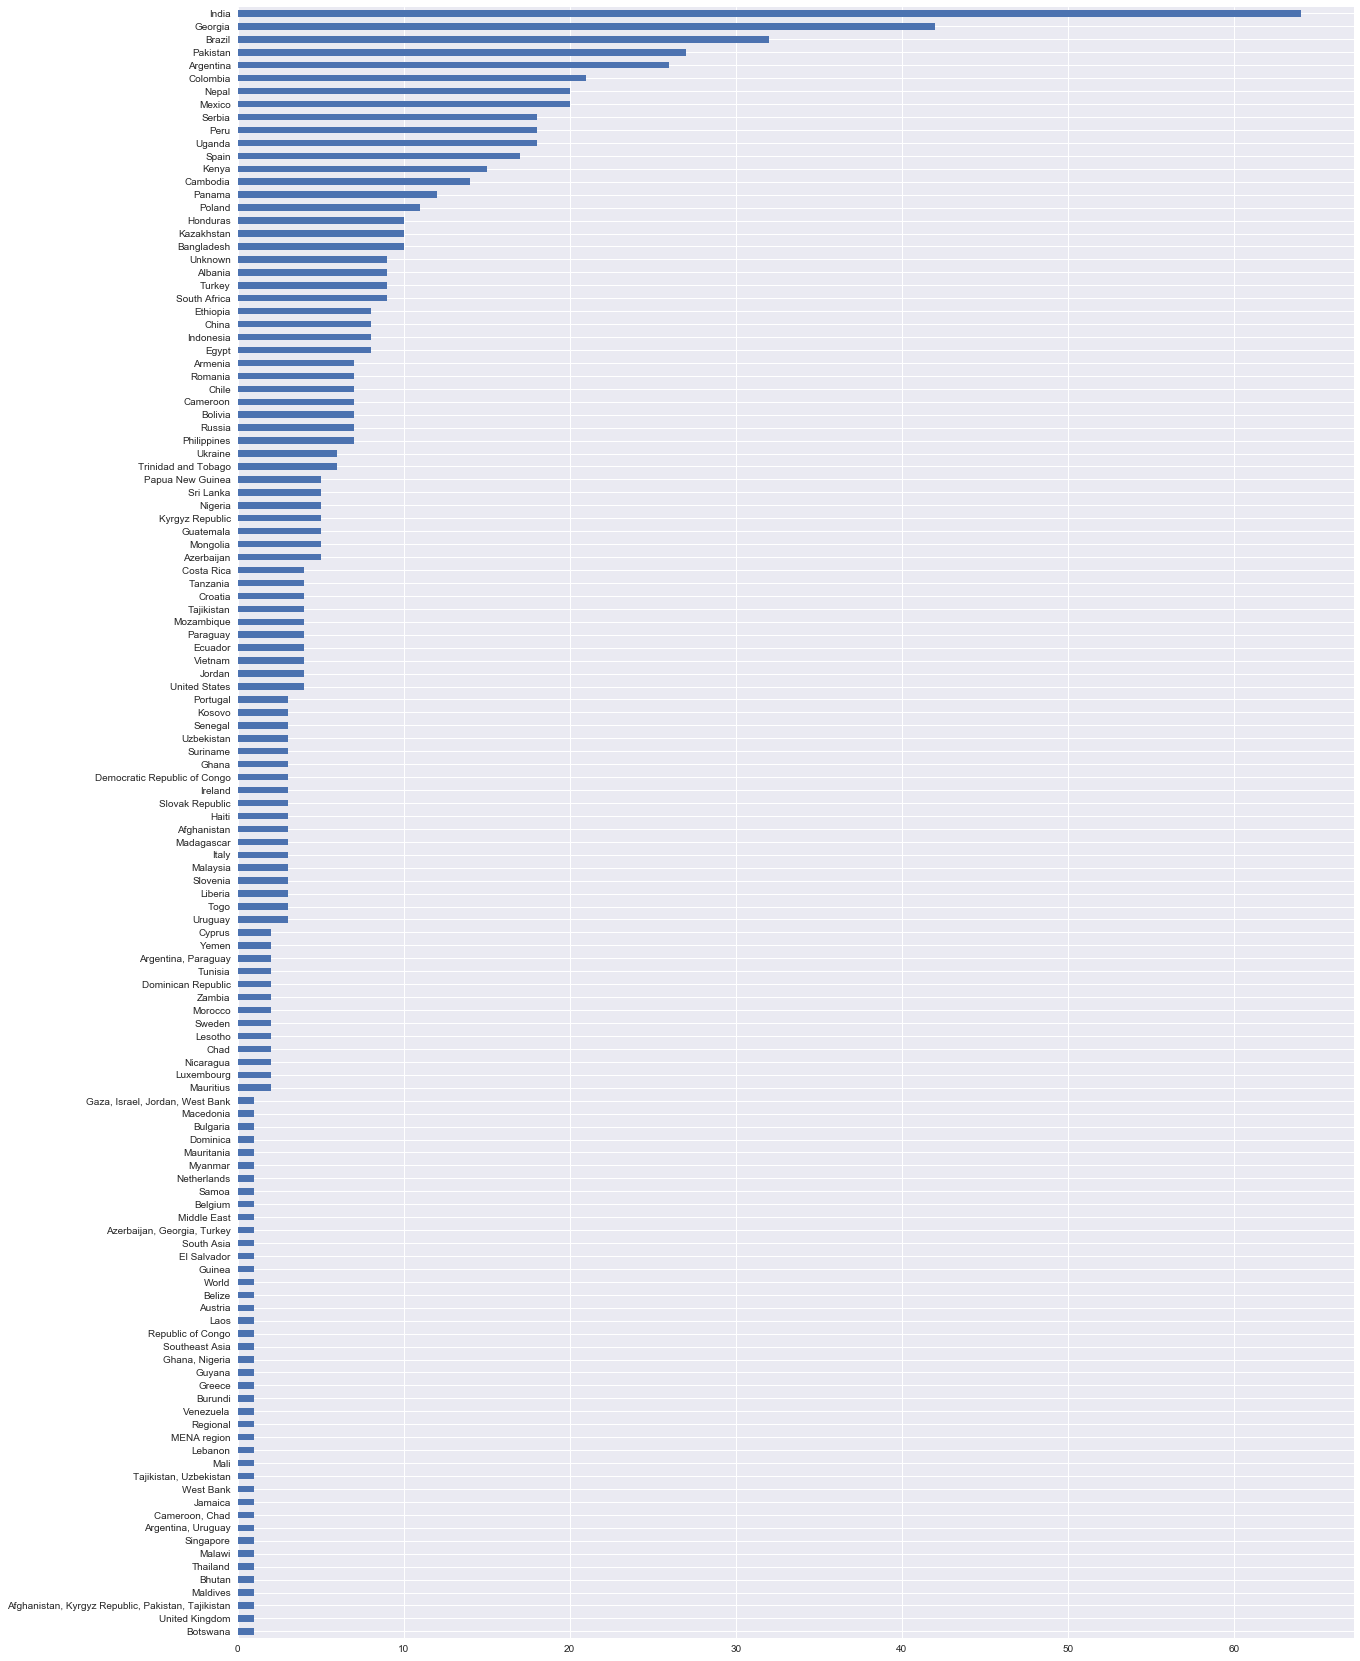

In [12]:
plt.rcParams["figure.figsize"] = [20,30]
country_size.plot.barh().invert_yaxis()

## IAM

14 unique accountability offices

In [13]:
pd.value_counts(ac['IAM'].values, sort=True, ascending=False)

IFC/MIGA Compliance Advisor/Ombudsman (IFC CAO)                                                                              262
Asian Development Bank Special Project Facilitator and Compliance Review Panel (ADB SPF CRP)                                 111
European Investment Bank Complaints Mechanism (EIB CM)                                                                        99
World Bank Inspection Panel (WB Panel)                                                                                        98
Inter-American Development Bank Independent Consultation and Investigation Mechanism (IDB MICI)                               97
European Bank for Reconstruction and Development Project Complaint Mechanism (EBRD PCM)                                       82
African Development Bank Independent Review Mechanism (AfDB IRM)                                                              23
European Bank for Reconstruction and Development Independent Resource Mechanism (EBRD IRM)       

## Bank

13 unique banks

In [35]:
pd.value_counts(ac['Bank'].values, sort=True, ascending=False)


IFC/MIGA                                            262
Asian Development Bank                              111
European Investment Bank                             99
World Bank                                           98
Inter-American Development Bank                      97
European Bank for Reconstruction and Development     95
African Development Bank                             23
Overseas Private Investment Corporation              11
Canadian Office of the Extractive Sector              6
Japan International Cooperation Agency                4
Netherlands Development Finance Company               4
Japan Bank for International Cooperation              2
United Nations Development Programme                  1
dtype: int64

In [14]:
pd.value_counts(ac['Bank'].values, sort=True, ascending=False)

IFC/MIGA                                            262
Asian Development Bank                              111
European Investment Bank                             99
World Bank                                           98
Inter-American Development Bank                      97
European Bank for Reconstruction and Development     95
African Development Bank                             23
Overseas Private Investment Corporation              11
Canadian Office of the Extractive Sector              6
Japan International Cooperation Agency                4
Netherlands Development Finance Company               4
Japan Bank for International Cooperation              2
United Nations Development Programme                  1
dtype: int64

In [41]:
ac.groupby(['IAM', 'Bank'])['Complaint Name'].count()

IAM                                                                                                                        Bank                                            
African Development Bank Independent Review Mechanism (AfDB IRM)                                                           African Development Bank                             23
Asian Development Bank Special Project Facilitator and Compliance Review Panel (ADB SPF CRP)                               Asian Development Bank                              111
Canadian Office of the Extractive Sector Corporate Social Responsibility Counsellor (COES CSR)                             Canadian Office of the Extractive Sector              6
European Bank for Reconstruction and Development Independent Resource Mechanism (EBRD IRM)                                 European Bank for Reconstruction and Development     13
European Bank for Reconstruction and Development Project Complaint Mechanism (EBRD PCM)                         

## External ID

In [38]:
pd.value_counts(ac['External ID'].values, sort=True, ascending=False)


99                             5
210                            4
53                             2
1                              2
103                            2
100                            2
90                             2
91                             2
104                            2
105                            2
82                             2
49                             2
94                             2
61                             2
9                              2
60                             2
93                             2
67                             2
92                             2
95                             2
84                             2
85                             2
8                              2
13                             2
12                             2
52                             2
88                             2
51                             2
57                             2
54                             2
          

## Status

In [39]:
pd.value_counts(ac['Status'].values, sort=True, ascending=False)

Closed Without Results                 546
Closed With Results                    114
Active                                  77
Closed With Results Outside Process     46
Monitoring                              29
Pre-Filed                                3
dtype: int64

## Status

In [8]:
ac['Status'].describe()

count                        815
unique                         6
top       Closed Without Results
freq                         546
Name: Status, dtype: object

In [10]:
pd.value_counts(ac['Status'].values, sort=True, ascending=False)

Closed Without Results                 546
Closed With Results                    114
Active                                  77
Closed With Results Outside Process     46
Monitoring                              29
Pre-Filed                                3
dtype: int64

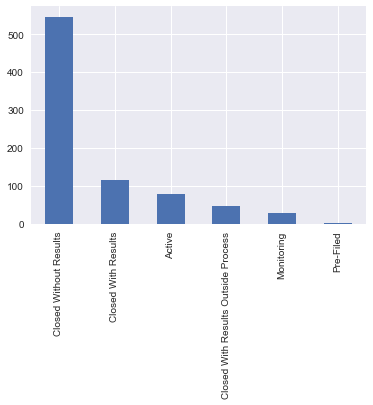

In [9]:
ac['Status'].value_counts().plot(kind='bar')

## Filer 

In [72]:
pd.value_counts(ac['Filer']).head(20)

Unknown                                                                                                                          244
Green Alternative                                                                                                                  7
CAO Vice President                                                                                                                 7
Association Green Alternative                                                                                                      5
CEE Bankwatch                                                                                                                      4
Social and Economic Rights Action Center                                                                                           2
Center for Ecology and Sustainable Development (CEKOR)                                                                             2
Corporate Accountability Desk                                        

## IFI Support 

International Finance Institutions

In [73]:
pd.value_counts(ac['IFI Support']).head(10)

Project/investment lending                       399
Equity Investment                                 33
Equity Investment, Project/investment lending     25
Advisory services                                 19
Project/investment lending, Risk Guarantee        13
Risk Guarantee                                    12
Other                                              9
No IFI involvement                                 8
Equity Investment, Financial intermediary          6
Advisory services, Project/investment lending      5
Name: IFI Support, dtype: int64

## Sector 

In [48]:
pd.value_counts(ac['Sector']).head()

Infrastructure                    180
Other                             107
Energy, Infrastructure             56
Extractives (oil, gas, mining)     50
Energy                             50
Name: Sector, dtype: int64

## Issues 

In [74]:
pd.value_counts(ac['Issues']).head(10)

Other                                                                   297
Displacement (physical and/or economic)                                  23
Procurement                                                              18
Consultation and disclosure, Displacement (physical and/or economic)     18
Labor                                                                    13
Displacement (physical and/or economic), Livelihoods                     10
Due diligence                                                            10
Consultation and disclosure, Due diligence                                8
Other environmental                                                       8
Consultation and disclosure                                               8
Name: Issues, dtype: int64

In [56]:
ac['Issues'].describe()

count       815
unique      312
top       Other
freq        297
Name: Issues, dtype: object

## Description

In [53]:
ac['Description'].describe()

count                                                    14
unique                                                   13
top       <p>\r\n<i>\r\nFull description available here:...
freq                                                      2
Name: Description, dtype: object

In [75]:
pd.value_counts(ac['Description']).head()

<p>\r\n<i>\r\nFull description available here: <a href="http://compliance.adb.org/dir0035p.nsf/attachments/GEO-R40-16-FOR%20WEB.pdf/$FILE/GEO-R40-16-FOR%20WEB.pdf" class = "u-blue-color"> http://compliance.adb.org/dir0035p.nsf/attachments/GEO-R40-16-FOR%20WEB.pdf/$FILE/GEO-R40-16-FOR%20WEB.pdf </a> \r\n</i> \r\n</p>\r\n<br>\r\n<p>\r\nThe Project is part of an overall investment program valued at $1.1 billion to be\r\nimplemented from 2010-2020 which aims to improve the reach, quality, and continuity of urban\r\ntransport in Georgia. To partially fund it, a multi-tranche financing facility (MFF) with a maximum\r\nfinancing amount of $300 million was approved by ADB in July 2010. Said MFF which is to be\r\nimplemented from 2010 to 2018, is for the (i) extension, rehabilitation, and improvement of\r\nurban transport infrastructure in Anaklia, Batumi, Kutaisi, Poti, Rustavi, and Tbilisi; (ii) increased\r\ninstitutional effectiveness, including the reorganization and reforms at the Tbilisi 

## Non-Compliance Found 

In [55]:
pd.value_counts(ac['Non-Compliance Found']).head()

False    731
True      84
Name: Non-Compliance Found, dtype: int64

## Filing Date 

In [59]:
pd.value_counts(ac['Filing Date']).head()

2005-07-05    19
2005-07-04    14
2005-07-07    11
2005-07-03    10
2013-07-01     9
Name: Filing Date, dtype: int64

In [58]:
ac['Filing Date'].groupby([ac['Filing Date'].dt.year]).agg('count')

Filing Date
1994.0      1
1995.0      4
1996.0      3
1997.0      2
1998.0      4
1999.0      7
2000.0      5
2001.0      9
2002.0      5
2003.0      5
2004.0     29
2005.0    108
2006.0     26
2007.0     29
2008.0     22
2009.0     53
2010.0     67
2011.0     86
2012.0     78
2013.0    110
2014.0     75
2015.0     68
2016.0      3
Name: Filing Date, dtype: int64

In [67]:
ac['Filing Date'].describe()

count                     799
unique                    558
top       2005-07-05 00:00:00
freq                       19
first     1994-10-24 00:00:00
last      2016-09-15 00:00:00
Name: Filing Date, dtype: object

## Registration Date 

In [76]:
pd.value_counts(ac['Registration Date']).head()

2010-09-20    4
2011-03-14    3
2014-12-22    3
2012-07-17    3
2015-07-01    2
Name: Registration Date, dtype: int64

In [77]:
ac['Registration Date'].groupby([ac['Registration Date'].dt.year]).agg('count')

Registration Date
1994.0     1
1995.0     2
1996.0     3
1997.0     2
1998.0     3
1999.0     7
2001.0     4
2002.0     2
2003.0     1
2004.0     7
2005.0     6
2006.0    10
2007.0    14
2008.0     1
2009.0    26
2010.0    32
2011.0    33
2012.0    29
2013.0    40
2014.0    29
2015.0    38
Name: Registration Date, dtype: int64

In [78]:
ac['Registration Date'].describe()

count                     290
unique                    263
top       2010-09-20 00:00:00
freq                        4
first     1994-11-03 00:00:00
last      2015-12-18 00:00:00
Name: Registration Date, dtype: object

Difference between Registration and Filing

## Eligibility Date 

In [79]:
ac['Eligibility Date'].groupby([ac['Eligibility Date'].dt.year]).agg('count')

Eligibility Date
1994.0     1
1995.0     1
1996.0     2
1997.0     3
1998.0     1
1999.0     4
2000.0     4
2001.0     6
2002.0     2
2003.0     1
2004.0    17
2005.0    15
2006.0     6
2007.0    15
2008.0    10
2009.0    15
2010.0    28
2011.0    39
2012.0    26
2013.0    34
2014.0    34
2015.0    18
Name: Eligibility Date, dtype: int64

In [80]:
ac['Eligibility Date'].describe()

count                     282
unique                    235
top       2004-06-08 00:00:00
freq                        6
first     1994-12-16 00:00:00
last      2015-12-09 00:00:00
Name: Eligibility Date, dtype: object

## Dispute Resolution

In [82]:
ac['Dispute Resolution Start'].groupby([ac['Dispute Resolution Start'].dt.year]).agg('count')

Dispute Resolution Start
2001.0     2
2003.0     1
2004.0     8
2005.0     2
2006.0     2
2007.0     7
2008.0     3
2009.0     6
2010.0     8
2011.0    18
2012.0    12
2013.0     9
2014.0     4
2015.0     7
Name: Dispute Resolution Start, dtype: int64

In [83]:
ac['Dispute Resolution Start'].describe()

count                      89
unique                     73
top       2004-09-01 00:00:00
freq                        4
first     2001-06-01 00:00:00
last      2015-10-20 00:00:00
Name: Dispute Resolution Start, dtype: object

In [84]:
ac['Dispute Resolution End'].groupby([ac['Dispute Resolution End'].dt.year]).agg('count')

Dispute Resolution End
2001.0     1
2004.0     1
2005.0     4
2006.0     5
2007.0     1
2008.0     7
2009.0     1
2010.0     7
2011.0    14
2012.0     7
2013.0     7
2014.0     9
2015.0     4
Name: Dispute Resolution End, dtype: int64

In [85]:
ac['Dispute Resolution End'].describe()

count                      68
unique                     57
top       2008-03-31 00:00:00
freq                        4
first     2001-07-01 00:00:00
last      2015-09-01 00:00:00
Name: Dispute Resolution End, dtype: object

In [ ]:
# Dispute Resolution Time Frame Delta 

In [87]:
# Resolution Status Distribution
pd.value_counts(ac['Dispute Resolution Status'])

Not Undertaken         690
Closed With Outcome    111
Name: Dispute Resolution Status, dtype: int64

In [89]:
pd.value_counts(ac['If No DR, Why?'])

Complaint originally deemed ineligible                                       385
Mech doesn't offer PS, or PS was not an option in this case                  118
IAM deemed unnecessary or inappropriate                                       43
MNE or government refused to participate                                      32
Not yet to PS stage                                                           17
Complainant chose not to have PS                                              16
Complainant never wanted PS                                                   15
Both complainants and MNE or government involved refused to go through PS     11
Matter resolved outside mech                                                   7
IFI funding or consideration of project ended                                  4
Complaint withdrawn                                                            4
Mech unable to contact complainant                                             3
Name: If No DR, Why?, dtype:

"Complaint originally deemed ineligible" and "Mech doesn't offer PS, or PS was not an option in this case" are worth digging into 

##  Compliance Review

In [90]:
ac['Compliance Review Start'].groupby([ac['Compliance Review Start'].dt.year]).agg('count')

Compliance Review Start
1994.0     1
1997.0     1
1999.0     1
2000.0     3
2001.0     3
2002.0     2
2003.0     1
2004.0     3
2005.0     3
2006.0     3
2007.0     8
2008.0     4
2009.0    10
2010.0    14
2011.0    14
2012.0    20
2013.0    18
2014.0    14
2015.0    18
Name: Compliance Review Start, dtype: int64

In [91]:
ac['Compliance Review Start'].describe()

count                     141
unique                    131
top       2015-06-01 00:00:00
freq                        3
first     1994-12-16 00:00:00
last      2015-12-03 00:00:00
Name: Compliance Review Start, dtype: object

In [92]:
ac['Compliance Review End'].groupby([ac['Compliance Review End'].dt.year]).agg('count')

Compliance Review End
1995.0     1
1998.0     1
2000.0     2
2001.0     1
2002.0     2
2003.0     2
2004.0     2
2005.0     2
2006.0     5
2007.0     2
2008.0     6
2009.0    10
2010.0    11
2011.0    13
2012.0     9
2013.0    13
2014.0    16
2015.0    12
Name: Compliance Review End, dtype: int64

In [93]:
ac['Compliance Review End'].describe()

count                     110
unique                    105
top       2010-10-15 00:00:00
freq                        2
first     1995-06-16 00:00:00
last      2015-12-03 00:00:00
Name: Compliance Review End, dtype: object

In [ ]:
# Compliance Time Frame Delta 

In [95]:
# Resolution Status Distribution
pd.value_counts(ac['Compliance Report Issued'])

False    728
True      87
Name: Compliance Report Issued, dtype: int64

In [96]:
## Dig into the compliance report itself... what is it? 

In [97]:
pd.value_counts(ac['If No CR, Why?'])

Complaint originally deemed ineligible                                                  407
Rejected at appraisal or similar                                                         47
IAM deemed unnecessary or inappropriate                                                  47
Not yet at CR stage                                                                      37
Case settled in PS, so CR not offered                                                    34
Matter resolved outside of mechanism                                                     18
Board did not authorize                                                                   7
Mech doesn't offer CR, or CR was not an option in this case                               6
Complainant did not refile                                                                6
IFI funding or consideration of project ended                                             6
Complaint withdrawn                                                             

##  Monitoring 

In [98]:
ac['Monitoring Start'].groupby([ac['Monitoring Start'].dt.year]).agg('count')

Monitoring Start
2001.0     1
2003.0     2
2004.0     3
2005.0     2
2006.0     7
2007.0     4
2008.0     5
2009.0     9
2010.0    10
2011.0     7
2012.0    10
2013.0    10
2014.0    14
2015.0    10
Name: Monitoring Start, dtype: int64

In [99]:
ac['Monitoring Start'].describe()

count                      94
unique                     85
top       2006-07-01 00:00:00
freq                        3
first     2001-06-01 00:00:00
last      2015-10-29 00:00:00
Name: Monitoring Start, dtype: object

In [100]:
ac['Monitoring End'].groupby([ac['Monitoring End'].dt.year]).agg('count')

Monitoring End
2005.0     5
2006.0     4
2007.0     2
2008.0     1
2009.0     5
2010.0     9
2011.0     5
2012.0     7
2013.0     6
2014.0    10
2015.0     9
Name: Monitoring End, dtype: int64

In [101]:
ac['Monitoring End'].describe()

count                      63
unique                     61
top       2013-06-01 00:00:00
freq                        2
first     2005-01-01 00:00:00
last      2015-12-10 00:00:00
Name: Monitoring End, dtype: object

In [ ]:
# Monitoring Time Frame Delta 

In [102]:
pd.value_counts(ac['If No Monitoring, Why?'])

Complaint originally deemed ineligible                        388
Case closed before monitoring                                 163
Not at monitoring stage yet                                    69
Complaint originally deemed ineligible or not registered       22
Monitoring not contemplated                                    20
Case was closed before monitoring                               5
Lack of follow-through                                          2
Case closed before monitoring, Not at monitoring stage yet      1
Project already ended                                           1
Board deemed monitoring unnecessary                             1
N/A because monitoring occurred                                 1
Name: If No Monitoring, Why?, dtype: int64

## Date Closed

In [103]:
ac['Date Closed'].describe()

count                     549
unique                    153
top       2013-07-01 00:00:00
freq                       14
first     1995-04-01 00:00:00
last      2015-12-01 00:00:00
Name: Date Closed, dtype: object

# Text Fields
## If No Eligibility, Why?

In [69]:
ac['If No Eligibility, Why?'].describe()

count                                203
unique                                64
top       Not within mechanism's mandate
freq                                  31
Name: If No Eligibility, Why?, dtype: object

In [71]:
pd.value_counts(ac['If No Eligibility, Why?']).head(20)

Not within mechanism's mandate                                                                                                       31
Good faith requirement not met                                                                                                       24
Mechanism forwarded complaint to another division within the Bank, Not within mechanism's mandate                                    13
DFI not financing project                                                                                                            12
Mechanism forwarded complaint to another division within the Bank, Not within mechanism's mandate, Raised procurement issues          8
Not filed by project affected people                                                                                                  7
Raised procurement issues                                                                                                             6
Management is addressing or has addressed concer